In [1]:
!pip install torch==1.9.0
!pip install fastparquet

     |████████████████████████████████| 831.4 MB 2.1 kB/s 
  Attempting uninstall: torch
    Found existing installation: torch 1.7.0
    Uninstalling torch-1.7.0:
      Successfully uninstalled torch-1.7.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
fastai 2.3.0 requires torch<1.8,>=1.7.0, but you have torch 1.9.0 which is incompatible.
allennlp 2.3.0 requires torch<1.9.0,>=1.6.0, but you have torch 1.9.0 which is incompatible.
     |████████████████████████████████| 1.5 MB 12.2 MB/s 
     |████████████████████████████████| 2.0 MB 12 kB/s 


In [2]:
import pandas as pd
pd.set_option('display.max_colwidth', None)
from sklearn import preprocessing as pp
from sklearn.model_selection import train_test_split
import scipy.sparse as sp
import numpy as np
import random
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import time
import matplotlib.pyplot as plt
from tqdm import tqdm
from typing import Optional

# Select device (CUDA if available)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Optional: make CUDA matmul faster on Ampere+
if torch.cuda.is_available():
    torch.backends.cuda.matmul.allow_tf32 = True
    torch.backends.cudnn.allow_tf32 = True

Using device: cuda


In [3]:
train = pd.read_parquet("/kaggle/input/yambda-50m-compressed/yambda/flat/50m/multi_event_train.parquet", engine="fastparquet")
val = pd.read_parquet("/kaggle/input/yambda-50m-compressed/yambda/flat/50m/multi_event_val.parquet", engine="fastparquet")
test = pd.read_parquet("/kaggle/input/yambda-50m-compressed/yambda/flat/50m/multi_event_test.parquet", engine="fastparquet")

train_pos = train[(train['event_type'] == 'like')].copy()

In [4]:
print("Train Size:", len(train))
print("Val Size:", len(val))
print("Test Size:", len(test))
print("Train positives:", len(train_pos))

Train Size: 47324518
Val Size: 223077
Test Size: 238408
Train positives: 872573


#### Label Encoding the User and Item IDs

In [5]:
le_user = pp.LabelEncoder()
le_item = pp.LabelEncoder()
# Fit encoders on positive train interactions only
train_pos['user_id_idx'] = le_user.fit_transform(train_pos['uid'].values)
train_pos['item_id_idx'] = le_item.fit_transform(train_pos['item_id'].values)

In [6]:
train_user_ids = train_pos['uid'].unique()
train_item_ids = train_pos['item_id'].unique()

print(len(train_user_ids), len(train_item_ids))

# Warm-start filter for val and test (only users/items seen in train positives)
val = val[(val['uid'].isin(train_user_ids)) & (val['item_id'].isin(train_item_ids))]
test = test[(test['uid'].isin(train_user_ids)) & (test['item_id'].isin(train_item_ids))]

print("Val after warm-start filter:", len(val))
print("Test after warm-start filter:", len(test))

8269 180239
Val after warm-start filter: 180593
Test after warm-start filter: 191231


In [7]:
# Build eval positives with same policy
val_pos = val[(val['event_type'] == 'like')].copy()
test_pos = test[(test['event_type'] == 'like')].copy()

# Transform val_pos and test_pos using encoders fitted on train_pos
val_pos['user_id_idx'] = le_user.transform(val_pos['uid'].values)
val_pos['item_id_idx'] = le_item.transform(val_pos['item_id'].values)

test_pos['user_id_idx'] = le_user.transform(test_pos['uid'].values)
test_pos['item_id_idx'] = le_item.transform(test_pos['item_id'].values)

print("Val positives:", len(val_pos))
print("Test positives:", len(test_pos))

Val positives: 3973
Test positives: 3649


In [8]:
n_users = train_pos['user_id_idx'].nunique()
n_items = train_pos['item_id_idx'].nunique()
print("Number of Unique Users : ", n_users)
print("Number of unique Items : ", n_items)

Number of Unique Users :  8269
Number of unique Items :  180239


### latent_dim is the length of the user/item embedding. 
### n_layers is the number of times we want to propagate our initial user/item embedding through the graph 

In [9]:
# Load external item embeddings and align to item_id_idx
import ast

emb_path = "/kaggle/input/yambda-50m-compressed/yambda/embeddings.parquet"
emb_df = pd.read_parquet(emb_path, engine="fastparquet")

# Map to train item indices (use positives-only index)
item_index_df = train_pos[['item_id', 'item_id_idx']].drop_duplicates()
emb_df = emb_df.merge(item_index_df, on='item_id', how='inner')

# Convert normalized_embed to arrays
def to_np(x):
    if isinstance(x, (list, np.ndarray)):
        return np.asarray(x, dtype=np.float32)
    if isinstance(x, str):
        try:
            return np.asarray(ast.literal_eval(x), dtype=np.float32)
        except Exception:
            raise ValueError("normalized_embed strings must be list-like representations")
    raise TypeError("normalized_embed must be list, ndarray, or string representation")

emb_arrays = emb_df['normalized_embed'].apply(to_np)
embed_dim = int(emb_arrays.iloc[0].shape[0])

# Build full matrix aligned by item_id_idx
item_emb_matrix = np.zeros((n_items, embed_dim), dtype=np.float32)
for idx, vec in zip(emb_df['item_id_idx'].values, emb_arrays.values):
    if vec.shape[0] != embed_dim:
        raise ValueError("Inconsistent embedding dimensions in normalized_embed column")
    item_emb_matrix[int(idx)] = vec

# If some items missing embeddings, initialize them with small random vectors (still frozen)
missing = np.where(~np.isfinite(item_emb_matrix).all(axis=1) | (np.abs(item_emb_matrix).sum(axis=1) == 0))[0]
if len(missing) > 0:
    rnd = np.random.RandomState(0)
    item_emb_matrix[missing] = rnd.normal(scale=0.01, size=(len(missing), embed_dim)).astype(np.float32)

# Override latent_dim to match external embedding dim
latent_dim = embed_dim

# Torch tensor for model init (placed on CPU; will move with model.to(device))
item_init_tensor = torch.from_numpy(item_emb_matrix)

print(f"Loaded external item embeddings: shape={item_emb_matrix.shape}, missing filled={len(missing)}")

Loaded external item embeddings: shape=(180239, 128), missing filled=10468


In [10]:
# Precompute user -> positive items mapping for fast negative sampling (positives only)
user_pos_items = train_pos.groupby('user_id_idx')['item_id_idx'].apply(set).to_dict()
user_pos_lists = train_pos.groupby('user_id_idx')['item_id_idx'].apply(list).to_dict()

# Simple, robust negative sampler: uniform over items, resample collisions vectorized
def sample_negatives(users, user_pos, n_itm, max_tries=10):
    users_arr = np.asarray(users)
    negs = np.random.randint(0, n_itm, size=len(users_arr))
    # mask of invalid negatives (collisions with positives)
    mask = np.array([negs[i] in user_pos.get(int(users_arr[i]), set()) for i in range(len(users_arr))])
    tries = 0
    while mask.any() and tries < max_tries:
        idx = np.where(mask)[0]
        resampled = np.random.randint(0, n_itm, size=len(idx))
        negs[idx] = resampled
        mask = np.array([negs[i] in user_pos.get(int(users_arr[i]), set()) for i in range(len(users_arr))])
        tries += 1
    # Fallback to per-entry loop for any stubborn collisions (rare)
    if mask.any():
        for i in np.where(mask)[0]:
            u = int(users_arr[i])
            pos = user_pos.get(u, set())
            while True:
                cand = random.randint(0, n_itm - 1)
                if cand not in pos:
                    negs[i] = cand
                    break
    return negs.tolist()

In [11]:
latent_dim = 64
n_layers = 3  

# Note: latent_dim will be overridden by external item embedding dim if provided.

In [12]:
def convert_to_sparse_tensor(dok_mtrx):
    
    dok_mtrx_coo = dok_mtrx.tocoo().astype(np.float32)
    values = dok_mtrx_coo.data
    indices = np.vstack((dok_mtrx_coo.row, dok_mtrx_coo.col))

    i = torch.LongTensor(indices)
    v = torch.FloatTensor(values)
    shape = dok_mtrx_coo.shape

    dok_mtrx_sparse_tensor = torch.sparse.FloatTensor(i, v, torch.Size(shape))

    return dok_mtrx_sparse_tensor

## **Metrics**
### Below Function gets the 4 different metrics out of Test Data -> Recall@K, Precision@K, NDCG@K, MAP@K where K is the top K items we would like to recommend to User. 

In [13]:
def get_metrics_full(user_Embed_wts, item_Embed_wts, n_users, n_items, train_data, eval_data, K,
                     device, user_batch_size=1024, item_chunk_size=8192):
    """
    Full-corpus, memory-safe metrics by batching users and chunking items.
    - Excludes training positives from candidates (true leave-one-out style).
    - Computes exact Top-K across all items without building a dense user×item matrix.

    Args:
      user_Embed_wts: torch.Tensor [n_users, d] on device
      item_Embed_wts: torch.Tensor [n_items, d] on device
      train_data: pd.DataFrame with columns user_id_idx, item_id_idx
      eval_data: pd.DataFrame with columns user_id_idx, item_id_idx
      K: int top-k
      device: torch.device
      user_batch_size: batch size for users
      item_chunk_size: chunk size for items
    Returns: (recall@K, precision@K, ndcg@K, map@K)
    """
    # Precompute train/eval positives on CPU
    train_pos = train_data.groupby('user_id_idx')['item_id_idx'].apply(set).to_dict()
    eval_pos = eval_data.groupby('user_id_idx')['item_id_idx'].apply(set).to_dict()
    eval_users = np.array(list(eval_pos.keys()), dtype=np.int64)

    user_Embed_wts = user_Embed_wts.to(device)
    item_Embed_wts = item_Embed_wts.to(device)

    recalls, precisions, ndcgs, maps = [], [], [], []

    if len(eval_users) == 0:
        return 0.0, 0.0, 0.0, 0.0

    K_eff_global = min(K, n_items)

    for u_start in tqdm(range(0, len(eval_users), user_batch_size), desc="Full eval: users", leave=False):
        batch_users = eval_users[u_start:u_start + user_batch_size]
        B = len(batch_users)
        if B == 0:
            continue
        u_idx_t = torch.tensor(batch_users, dtype=torch.long, device=device)
        u_vecs = user_Embed_wts[u_idx_t]  # [B, d]

        # Running top-K buffers per batch
        top_scores = torch.full((B, K_eff_global), -float('inf'), device=device)
        top_items = torch.full((B, K_eff_global), -1, dtype=torch.long, device=device)

        for i_start in range(0, n_items, item_chunk_size):
            i_end = min(i_start + item_chunk_size, n_items)
            C = i_end - i_start
            items_idx = torch.arange(i_start, i_end, device=device, dtype=torch.long)
            i_vecs = item_Embed_wts[items_idx]  # [C, d]

            # Scores [B, C]
            scores = torch.matmul(u_vecs, i_vecs.T)

            # Mask training positives by setting -inf at those positions
            rows_list = []
            cols_list = []
            for r, u in enumerate(batch_users):
                pos = train_pos.get(int(u), set())
                if pos:
                    for p in pos:
                        if p >= i_start and p < i_end:
                            rows_list.append(r)
                            cols_list.append(p - i_start)
            if rows_list:
                rows_t = torch.tensor(rows_list, device=device, dtype=torch.long)
                cols_t = torch.tensor(cols_list, device=device, dtype=torch.long)
                scores[rows_t, cols_t] = -float('inf')

            k_chunk = min(K_eff_global, C)
            chunk_scores, chunk_idx = torch.topk(scores, k_chunk, dim=1)
            chunk_items = items_idx[chunk_idx]

            merged_scores = torch.cat([top_scores, chunk_scores], dim=1)
            merged_items = torch.cat([top_items, chunk_items], dim=1)
            top_scores, top_order = torch.topk(merged_scores, K_eff_global, dim=1)
            top_items = merged_items.gather(1, top_order)

            # Cleanup
            del scores, chunk_scores, chunk_idx, merged_scores, merged_items, items_idx, i_vecs
            if torch.cuda.is_available() and 'cuda' in str(device):
                torch.cuda.empty_cache()

        # Compute metrics on CPU for this user batch
        top_items_cpu = top_items.detach().cpu().numpy()
        for r, u in enumerate(batch_users):
            preds = [int(x) for x in top_items_cpu[r] if int(x) >= 0]
            pos_eval_set = eval_pos.get(int(u), set())
            if not pos_eval_set:
                continue

            k_eff_user = min(K, len(preds))
            hits = [1 if it in pos_eval_set else 0 for it in preds[:k_eff_user]]

            recall = sum(hits) / max(1, len(pos_eval_set))
            precision = sum(hits) / max(1, k_eff_user)

            idcg = sum(1.0 / np.log1p(i + 2) for i in range(min(len(pos_eval_set), k_eff_user)))
            dcg = sum(h / np.log1p(i + 2) for i, h in enumerate(hits))
            ndcg = (dcg / idcg) if idcg > 0 else 0.0

            cumsum = 0
            ap_sum = 0.0
            for i, h in enumerate(hits, start=1):
                cumsum += h
                ap_sum += (cumsum / i) * h
            ap = ap_sum / max(1, len(pos_eval_set))

            recalls.append(recall)
            precisions.append(precision)
            ndcgs.append(ndcg)
            maps.append(ap)

        # free batch buffers
        del u_vecs, top_scores, top_items, u_idx_t
        if torch.cuda.is_available() and 'cuda' in str(device):
            torch.cuda.empty_cache()

    return float(np.mean(recalls) if recalls else 0.0), \
           float(np.mean(precisions) if precisions else 0.0), \
           float(np.mean(ndcgs) if ndcgs else 0.0), \
           float(np.mean(maps) if maps else 0.0)


##  **LightGCN Model**
### **get_A_tilda** function is used to get A_tilda which will be multiplied with initial user/item embedding (E0) to create embedding at different layers (n_layers = 3) in **propagate_through_layers** function
### **forward** function is used to look up for initial(E0) and final embedding of a user/item

In [14]:
class LightGCN(nn.Module):
    def __init__(self, data, n_users, n_items, n_layers, latent_dim, item_init=None):
        super(LightGCN, self).__init__()
        self.data = data
        self.n_users = n_users
        self.n_items = n_items
        self.n_layers = n_layers
        # If external item embeddings are provided, set latent_dim from them
        if item_init is not None:
            self.latent_dim = int(item_init.shape[1])
        else:
            self.latent_dim = latent_dim
        self.init_embedding(item_init)
        # Register adjacency as a buffer so it moves with .to(device)
        self.register_buffer("norm_adj_mat_sparse_tensor", self.get_A_tilda().coalesce())

    def init_embedding(self, item_init: Optional[torch.Tensor]):
        # Trainable user embeddings
        self.user_E = nn.Embedding(self.n_users, self.latent_dim)
        nn.init.xavier_uniform_(self.user_E.weight)
        self.user_E.weight = nn.Parameter(self.user_E.weight)
        # Frozen item embeddings (buffer)
        if item_init is not None:
            # Ensure correct dtype/shape
            item_init = item_init.float()
            if item_init.shape != (self.n_items, self.latent_dim):
                raise ValueError(f"item_init shape {tuple(item_init.shape)} does not match (n_items, latent_dim)=({self.n_items}, {self.latent_dim})")
            self.register_buffer('item_E', item_init)
        else:
            # If no external item embeddings, fall back to random init but keep them frozen as buffer? Better: make them trainable
            rand_items = torch.empty(self.n_items, self.latent_dim)
            nn.init.xavier_uniform_(rand_items)
            self.register_buffer('item_E', rand_items)

    def get_A_tilda(self):
        R = sp.dok_matrix((self.n_users, self.n_items), dtype=np.float32)
        R[self.data['user_id_idx'], self.data['item_id_idx']] = 1.0

        adj_mat = sp.dok_matrix(
            (self.n_users + self.n_items, self.n_users + self.n_items), dtype=np.float32
        )
        adj_mat = adj_mat.tolil()
        R = R.tolil()

        adj_mat[: self.n_users, self.n_users :] = R
        adj_mat[self.n_users :, : self.n_users] = R.T
        adj_mat = adj_mat.todok()

        rowsum = np.array(adj_mat.sum(1))
        d_inv = np.power(rowsum + 1e-9, -0.5).flatten()
        d_inv[np.isinf(d_inv)] = 0.0
        d_mat_inv = sp.diags(d_inv)
        norm_adj_mat = d_mat_inv.dot(adj_mat)
        norm_adj_mat = norm_adj_mat.dot(d_mat_inv)

        # Convert the dok_matrix to sparse tensor
        norm_adj_mat_coo = norm_adj_mat.tocoo().astype(np.float32)
        values = norm_adj_mat_coo.data
        indices = np.vstack((norm_adj_mat_coo.row, norm_adj_mat_coo.col))

        i = torch.LongTensor(indices)
        v = torch.FloatTensor(values)
        shape = norm_adj_mat_coo.shape

        norm_adj_mat_sparse_tensor = torch.sparse.FloatTensor(i, v, torch.Size(shape))

        return norm_adj_mat_sparse_tensor

    def propagate_through_layers(self):
        # Build initial embedding by concatenating user (trainable) and item (frozen) embeddings
        E0 = torch.cat([self.user_E.weight, self.item_E], dim=0)
        all_layer_embedding = [E0]
        E_lyr = E0

        for _ in range(self.n_layers):
            E_lyr = torch.sparse.mm(self.norm_adj_mat_sparse_tensor, E_lyr)
            all_layer_embedding.append(E_lyr)

        all_layer_embedding = torch.stack(all_layer_embedding)
        mean_layer_embedding = torch.mean(all_layer_embedding, dim=0)

        final_user_Embed, final_item_Embed = torch.split(mean_layer_embedding, [self.n_users, self.n_items])
        initial_user_Embed, initial_item_Embed = torch.split(E0, [self.n_users, self.n_items])

        return final_user_Embed, final_item_Embed, initial_user_Embed, initial_item_Embed

    def forward(self, users, pos_items, neg_items):
        final_user_Embed, final_item_Embed, initial_user_Embed, initial_item_Embed = self.propagate_through_layers()

        users_emb, pos_emb, neg_emb = final_user_Embed[users], final_item_Embed[pos_items], final_item_Embed[neg_items]
        userEmb0,  posEmb0, negEmb0 = initial_user_Embed[users], initial_item_Embed[pos_items], initial_item_Embed[neg_items]

        return users_emb, pos_emb, neg_emb, userEmb0,  posEmb0, negEmb0

In [15]:
# Initialize model with frozen external item embeddings
lightGCN = LightGCN(train_pos, n_users, n_items, n_layers, latent_dim, item_init=item_init_tensor).to(device)

In [16]:
print("Size of Learnable Embedding : ", list(lightGCN.parameters())[0].size())

Size of Learnable Embedding :  torch.Size([8269, 128])


### **BPR Loss**

In [17]:
def bpr_loss(users, users_emb, pos_emb, neg_emb, userEmb0,  posEmb0, negEmb0):
  
    reg_loss = (1/2)*(userEmb0.norm().pow(2) + 
                    posEmb0.norm().pow(2)  +
                    negEmb0.norm().pow(2))/float(len(users))
    pos_scores = torch.mul(users_emb, pos_emb)
    pos_scores = torch.sum(pos_scores, dim=1)
    neg_scores = torch.mul(users_emb, neg_emb)
    neg_scores = torch.sum(neg_scores, dim=1)
        
    loss = torch.mean(torch.nn.functional.softplus(neg_scores - pos_scores))
        
    return loss, reg_loss

### Data Loader - Samples users and for each user it sample 1 postive item - which User interacted with in Training Data and 1 negative item - with which User have not interacted.

In [18]:
def data_loader(data, batch_size, n_usr, n_itm):
    # Build the list of candidate users
    indices = list(range(n_usr))

    if n_usr < batch_size:
        users = [random.choice(indices) for _ in range(batch_size)]
    else:
        users = random.sample(indices, batch_size)

    users.sort()

    # Sample one positive per user from precomputed lists
    pos_items = [random.choice(user_pos_lists[u]) for u in users]
    
    # Sample robust negatives per user (uniform, excluding user's positives)
    neg_items = sample_negatives(users, user_pos_items, n_itm)

    return users, pos_items, neg_items

In [19]:
optimizer = torch.optim.Adam(lightGCN.parameters(), lr = 1e-3)

In [20]:
EPOCHS = 100
BATCH_SIZE = 1024 
DECAY = 0.0001
K = 10

# Full-corpus evaluation controls (exact metrics with batching/chunking)
USER_BATCH_SIZE_FULL = 512      # users per batch for full eval (tune for memory/time)
ITEM_CHUNK_SIZE_FULL = 8192     # items per chunk for full eval (tune for memory/time)


### **Training Loop**

In [21]:
from tqdm import tqdm

loss_list_epoch = []
MF_loss_list_epoch = []
reg_loss_list_epoch = []

val_recall_list = []
val_precision_list = []
val_ndcg_list = []
val_map_list = []

train_time_list = []
eval_time_list = []

best_ndcg = -1

for epoch in range(EPOCHS):
    n_batch = int(len(train_pos) / BATCH_SIZE)
  
    final_loss_list = []
    MF_loss_list = []
    reg_loss_list = []
  
    train_start_time = time.time()
    lightGCN.train()

    # tqdm for batches (inner loop)
    batch_iter = tqdm(range(n_batch), desc=f"Epoch {epoch+1}/{EPOCHS}", leave=False)
    for batch_idx in batch_iter:
        optimizer.zero_grad()

        users, pos_items, neg_items = data_loader(train_pos, BATCH_SIZE, n_users, n_items)
        users_t = torch.tensor(users, dtype=torch.long, device=device)
        pos_t = torch.tensor(pos_items, dtype=torch.long, device=device)
        neg_t = torch.tensor(neg_items, dtype=torch.long, device=device)

        users_emb, pos_emb, neg_emb, userEmb0, posEmb0, negEmb0 = lightGCN.forward(users_t, pos_t, neg_t)

        mf_loss, reg_loss = bpr_loss(users_t, users_emb, pos_emb, neg_emb, userEmb0, posEmb0, negEmb0)
        reg_loss = DECAY * reg_loss
        final_loss = mf_loss + reg_loss

        final_loss.backward()
        optimizer.step()

        final_loss_list.append(final_loss.item())
        MF_loss_list.append(mf_loss.item())
        reg_loss_list.append(reg_loss.item())

        # update tqdm batch bar
        batch_iter.set_postfix({
            "Loss": f"{np.mean(final_loss_list):.4f}",
            "MF": f"{np.mean(MF_loss_list):.4f}",
            "Reg": f"{np.mean(reg_loss_list):.4f}"
        })

    train_end_time = time.time()
    train_time = train_end_time - train_start_time

    # Validation: full-corpus exact evaluation (memory-safe via batching/chunking)
    lightGCN.eval()
    with torch.no_grad():
        final_user_Embed, final_item_Embed, initial_user_Embed, initial_item_Embed = lightGCN.propagate_through_layers()
        # Keep on device for faster scoring
        fu = final_user_Embed.detach()
        fi = final_item_Embed.detach()
        val_recall, val_precision, val_ndcg, val_map = get_metrics_full(
            fu, fi, n_users, n_items, train_pos, val_pos, K, device=device,
            user_batch_size=USER_BATCH_SIZE_FULL, item_chunk_size=ITEM_CHUNK_SIZE_FULL
        )

    if val_ndcg > best_ndcg:
        best_ndcg = val_ndcg
        # Save CPU tensors for portability
        torch.save(fu.detach().cpu(), 'final_user_Embed.pt')
        torch.save(fi.detach().cpu(), 'final_item_Embed.pt')
        torch.save(initial_user_Embed.detach().cpu(), 'initial_user_Embed.pt')
        torch.save(initial_item_Embed.detach().cpu(), 'initial_item_Embed.pt')

    eval_time = time.time() - train_end_time

    # store metrics
    loss_list_epoch.append(round(np.mean(final_loss_list), 4))
    MF_loss_list_epoch.append(round(np.mean(MF_loss_list), 4))
    reg_loss_list_epoch.append(round(np.mean(reg_loss_list), 4))

    val_recall_list.append(round(val_recall, 4))
    val_precision_list.append(round(val_precision, 4))
    val_ndcg_list.append(round(val_ndcg, 4))
    val_map_list.append(round(val_map, 4))

    train_time_list.append(train_time)
    eval_time_list.append(eval_time)

    # tqdm for epoch-level display
    tqdm.write(
        f"Epoch {epoch+1}/{EPOCHS} | "
        f"Loss: {np.mean(final_loss_list):.4f} | "
        f"Val NDCG: {val_ndcg:.4f} | "
        f"Val Recall: {val_recall:.4f} | "
        f"Val Precision: {val_precision:.4f} | "
        f"Val MAP: {val_map:.4f} | "
        f"Train Time: {train_time:.1f}s | Eval Time: {eval_time:.1f}s"
    )


Epoch 2/100:   0%|          | 1/852 [00:00<01:27,  9.74it/s, Loss=0.2764, MF=0.2757, Reg=0.0008]

Epoch 1/100 | Loss: 0.4234 | Val NDCG: 0.0029 | Val Recall: 0.0039 | Val Precision: 0.0012 | Val MAP: 0.0011 | Train Time: 88.2s | Eval Time: 1.5s


Epoch 3/100:   0%|          | 1/852 [00:00<01:27,  9.68it/s, Loss=0.1829, MF=0.1814, Reg=0.0015]

Epoch 2/100 | Loss: 0.2269 | Val NDCG: 0.0029 | Val Recall: 0.0039 | Val Precision: 0.0012 | Val MAP: 0.0011 | Train Time: 88.0s | Eval Time: 1.0s


Epoch 4/100:   0%|          | 1/852 [00:00<01:29,  9.56it/s, Loss=0.1786, MF=0.1766, Reg=0.0020]

Epoch 3/100 | Loss: 0.1717 | Val NDCG: 0.0033 | Val Recall: 0.0048 | Val Precision: 0.0013 | Val MAP: 0.0012 | Train Time: 88.6s | Eval Time: 1.7s


Epoch 5/100:   0%|          | 1/852 [00:00<01:29,  9.46it/s, Loss=0.1096, MF=0.1071, Reg=0.0025]

Epoch 4/100 | Loss: 0.1399 | Val NDCG: 0.0039 | Val Recall: 0.0056 | Val Precision: 0.0014 | Val MAP: 0.0015 | Train Time: 88.1s | Eval Time: 1.8s


Epoch 6/100:   0%|          | 1/852 [00:00<01:28,  9.60it/s, Loss=0.0966, MF=0.0936, Reg=0.0030]

Epoch 5/100 | Loss: 0.1196 | Val NDCG: 0.0039 | Val Recall: 0.0055 | Val Precision: 0.0013 | Val MAP: 0.0016 | Train Time: 88.0s | Eval Time: 1.7s


Epoch 7/100:   0%|          | 1/852 [00:00<01:29,  9.53it/s, Loss=0.0926, MF=0.0891, Reg=0.0035]

Epoch 6/100 | Loss: 0.1053 | Val NDCG: 0.0041 | Val Recall: 0.0058 | Val Precision: 0.0015 | Val MAP: 0.0015 | Train Time: 88.0s | Eval Time: 1.7s


Epoch 8/100:   0%|          | 1/852 [00:00<01:29,  9.52it/s, Loss=0.0787, MF=0.0749, Reg=0.0038]

Epoch 7/100 | Loss: 0.0948 | Val NDCG: 0.0046 | Val Recall: 0.0067 | Val Precision: 0.0017 | Val MAP: 0.0017 | Train Time: 88.1s | Eval Time: 1.7s


Epoch 9/100:   0%|          | 1/852 [00:00<01:29,  9.56it/s, Loss=0.0827, MF=0.0785, Reg=0.0042]

Epoch 8/100 | Loss: 0.0859 | Val NDCG: 0.0047 | Val Recall: 0.0063 | Val Precision: 0.0020 | Val MAP: 0.0017 | Train Time: 88.3s | Eval Time: 1.7s


Epoch 10/100:   0%|          | 1/852 [00:00<01:30,  9.44it/s, Loss=0.0759, MF=0.0713, Reg=0.0046]

Epoch 9/100 | Loss: 0.0789 | Val NDCG: 0.0048 | Val Recall: 0.0063 | Val Precision: 0.0021 | Val MAP: 0.0018 | Train Time: 88.3s | Eval Time: 1.7s


Epoch 11/100:   0%|          | 1/852 [00:00<01:33,  9.06it/s, Loss=0.0540, MF=0.0491, Reg=0.0050]

Epoch 10/100 | Loss: 0.0756 | Val NDCG: 0.0049 | Val Recall: 0.0064 | Val Precision: 0.0021 | Val MAP: 0.0018 | Train Time: 88.4s | Eval Time: 1.7s


Epoch 12/100:   0%|          | 1/852 [00:00<01:27,  9.67it/s, Loss=0.0676, MF=0.0623, Reg=0.0053]

Epoch 11/100 | Loss: 0.0713 | Val NDCG: 0.0052 | Val Recall: 0.0069 | Val Precision: 0.0022 | Val MAP: 0.0019 | Train Time: 88.0s | Eval Time: 1.6s


Epoch 13/100:   0%|          | 1/852 [00:00<01:29,  9.49it/s, Loss=0.0605, MF=0.0550, Reg=0.0055]

Epoch 12/100 | Loss: 0.0680 | Val NDCG: 0.0058 | Val Recall: 0.0077 | Val Precision: 0.0026 | Val MAP: 0.0021 | Train Time: 88.0s | Eval Time: 1.7s


Epoch 14/100:   0%|          | 1/852 [00:00<01:28,  9.60it/s, Loss=0.0709, MF=0.0651, Reg=0.0058]

Epoch 13/100 | Loss: 0.0650 | Val NDCG: 0.0061 | Val Recall: 0.0084 | Val Precision: 0.0027 | Val MAP: 0.0022 | Train Time: 87.9s | Eval Time: 1.7s


Epoch 15/100:   0%|          | 1/852 [00:00<01:28,  9.58it/s, Loss=0.0641, MF=0.0580, Reg=0.0061]

Epoch 14/100 | Loss: 0.0621 | Val NDCG: 0.0062 | Val Recall: 0.0083 | Val Precision: 0.0026 | Val MAP: 0.0024 | Train Time: 88.2s | Eval Time: 1.7s


Epoch 16/100:   0%|          | 1/852 [00:00<01:29,  9.47it/s, Loss=0.0629, MF=0.0566, Reg=0.0064]

Epoch 15/100 | Loss: 0.0609 | Val NDCG: 0.0064 | Val Recall: 0.0085 | Val Precision: 0.0027 | Val MAP: 0.0024 | Train Time: 88.0s | Eval Time: 1.7s


Epoch 17/100:   0%|          | 1/852 [00:00<01:29,  9.56it/s, Loss=0.0527, MF=0.0461, Reg=0.0066]

Epoch 16/100 | Loss: 0.0582 | Val NDCG: 0.0067 | Val Recall: 0.0086 | Val Precision: 0.0027 | Val MAP: 0.0029 | Train Time: 88.0s | Eval Time: 1.7s


Epoch 18/100:   0%|          | 1/852 [00:00<01:27,  9.68it/s, Loss=0.0472, MF=0.0404, Reg=0.0067]

Epoch 17/100 | Loss: 0.0572 | Val NDCG: 0.0067 | Val Recall: 0.0086 | Val Precision: 0.0027 | Val MAP: 0.0031 | Train Time: 88.2s | Eval Time: 1.7s


Epoch 19/100:   0%|          | 1/852 [00:00<01:27,  9.75it/s, Loss=0.0627, MF=0.0556, Reg=0.0071]

Epoch 18/100 | Loss: 0.0556 | Val NDCG: 0.0066 | Val Recall: 0.0085 | Val Precision: 0.0027 | Val MAP: 0.0026 | Train Time: 88.0s | Eval Time: 1.0s


Epoch 20/100:   0%|          | 1/852 [00:00<01:27,  9.67it/s, Loss=0.0384, MF=0.0312, Reg=0.0072]

Epoch 19/100 | Loss: 0.0540 | Val NDCG: 0.0067 | Val Recall: 0.0086 | Val Precision: 0.0028 | Val MAP: 0.0027 | Train Time: 88.0s | Eval Time: 1.0s


Epoch 21/100:   0%|          | 1/852 [00:00<01:28,  9.65it/s, Loss=0.0398, MF=0.0324, Reg=0.0073]

Epoch 20/100 | Loss: 0.0524 | Val NDCG: 0.0068 | Val Recall: 0.0088 | Val Precision: 0.0029 | Val MAP: 0.0027 | Train Time: 88.0s | Eval Time: 1.7s


Epoch 22/100:   0%|          | 1/852 [00:00<01:28,  9.66it/s, Loss=0.0424, MF=0.0350, Reg=0.0074]

Epoch 21/100 | Loss: 0.0518 | Val NDCG: 0.0068 | Val Recall: 0.0087 | Val Precision: 0.0028 | Val MAP: 0.0027 | Train Time: 88.1s | Eval Time: 1.0s


Epoch 23/100:   0%|          | 1/852 [00:00<01:28,  9.57it/s, Loss=0.0363, MF=0.0285, Reg=0.0077]

Epoch 22/100 | Loss: 0.0502 | Val NDCG: 0.0069 | Val Recall: 0.0087 | Val Precision: 0.0028 | Val MAP: 0.0028 | Train Time: 88.0s | Eval Time: 1.7s


Epoch 24/100:   0%|          | 1/852 [00:00<01:28,  9.66it/s, Loss=0.0475, MF=0.0396, Reg=0.0079]

Epoch 23/100 | Loss: 0.0497 | Val NDCG: 0.0069 | Val Recall: 0.0088 | Val Precision: 0.0029 | Val MAP: 0.0027 | Train Time: 88.2s | Eval Time: 1.7s


Epoch 25/100:   0%|          | 1/852 [00:00<01:27,  9.68it/s, Loss=0.0512, MF=0.0431, Reg=0.0080]

Epoch 24/100 | Loss: 0.0486 | Val NDCG: 0.0070 | Val Recall: 0.0090 | Val Precision: 0.0029 | Val MAP: 0.0027 | Train Time: 88.3s | Eval Time: 1.7s


Epoch 26/100:   0%|          | 1/852 [00:00<01:29,  9.50it/s, Loss=0.0619, MF=0.0538, Reg=0.0081]

Epoch 25/100 | Loss: 0.0485 | Val NDCG: 0.0071 | Val Recall: 0.0092 | Val Precision: 0.0029 | Val MAP: 0.0029 | Train Time: 87.9s | Eval Time: 1.7s


Epoch 27/100:   0%|          | 1/852 [00:00<01:27,  9.68it/s, Loss=0.0515, MF=0.0432, Reg=0.0083]

Epoch 26/100 | Loss: 0.0476 | Val NDCG: 0.0079 | Val Recall: 0.0108 | Val Precision: 0.0031 | Val MAP: 0.0031 | Train Time: 88.0s | Eval Time: 1.7s


Epoch 28/100:   0%|          | 1/852 [00:00<01:30,  9.37it/s, Loss=0.0402, MF=0.0318, Reg=0.0084]

Epoch 27/100 | Loss: 0.0463 | Val NDCG: 0.0080 | Val Recall: 0.0109 | Val Precision: 0.0032 | Val MAP: 0.0031 | Train Time: 88.1s | Eval Time: 1.7s


Epoch 29/100:   0%|          | 1/852 [00:00<01:28,  9.60it/s, Loss=0.0430, MF=0.0344, Reg=0.0086]

Epoch 28/100 | Loss: 0.0464 | Val NDCG: 0.0081 | Val Recall: 0.0110 | Val Precision: 0.0033 | Val MAP: 0.0032 | Train Time: 88.3s | Eval Time: 1.7s


Epoch 30/100:   0%|          | 1/852 [00:00<01:28,  9.62it/s, Loss=0.0450, MF=0.0364, Reg=0.0087]

Epoch 29/100 | Loss: 0.0455 | Val NDCG: 0.0086 | Val Recall: 0.0121 | Val Precision: 0.0034 | Val MAP: 0.0032 | Train Time: 88.7s | Eval Time: 1.7s


Epoch 31/100:   0%|          | 1/852 [00:00<01:27,  9.67it/s, Loss=0.0431, MF=0.0341, Reg=0.0090]

Epoch 30/100 | Loss: 0.0449 | Val NDCG: 0.0087 | Val Recall: 0.0122 | Val Precision: 0.0035 | Val MAP: 0.0034 | Train Time: 88.3s | Eval Time: 1.7s


Epoch 32/100:   0%|          | 1/852 [00:00<01:27,  9.69it/s, Loss=0.0504, MF=0.0414, Reg=0.0090]

Epoch 31/100 | Loss: 0.0440 | Val NDCG: 0.0087 | Val Recall: 0.0121 | Val Precision: 0.0034 | Val MAP: 0.0034 | Train Time: 88.0s | Eval Time: 1.0s


Epoch 33/100:   0%|          | 1/852 [00:00<01:27,  9.75it/s, Loss=0.0319, MF=0.0228, Reg=0.0091]

Epoch 32/100 | Loss: 0.0438 | Val NDCG: 0.0084 | Val Recall: 0.0114 | Val Precision: 0.0034 | Val MAP: 0.0033 | Train Time: 88.0s | Eval Time: 1.0s


Epoch 34/100:   0%|          | 1/852 [00:00<01:28,  9.66it/s, Loss=0.0539, MF=0.0446, Reg=0.0093]

Epoch 33/100 | Loss: 0.0432 | Val NDCG: 0.0088 | Val Recall: 0.0120 | Val Precision: 0.0037 | Val MAP: 0.0033 | Train Time: 87.9s | Eval Time: 1.7s


Epoch 35/100:   0%|          | 1/852 [00:00<01:28,  9.59it/s, Loss=0.0391, MF=0.0300, Reg=0.0092]

Epoch 34/100 | Loss: 0.0427 | Val NDCG: 0.0088 | Val Recall: 0.0120 | Val Precision: 0.0037 | Val MAP: 0.0034 | Train Time: 88.0s | Eval Time: 1.7s


Epoch 36/100:   0%|          | 1/852 [00:00<01:28,  9.64it/s, Loss=0.0422, MF=0.0328, Reg=0.0094]

Epoch 35/100 | Loss: 0.0419 | Val NDCG: 0.0087 | Val Recall: 0.0119 | Val Precision: 0.0036 | Val MAP: 0.0033 | Train Time: 88.1s | Eval Time: 1.0s


Epoch 37/100:   0%|          | 1/852 [00:00<01:28,  9.64it/s, Loss=0.0439, MF=0.0346, Reg=0.0093]

Epoch 36/100 | Loss: 0.0422 | Val NDCG: 0.0088 | Val Recall: 0.0120 | Val Precision: 0.0037 | Val MAP: 0.0034 | Train Time: 88.3s | Eval Time: 1.0s


Epoch 38/100:   0%|          | 1/852 [00:00<01:28,  9.64it/s, Loss=0.0418, MF=0.0321, Reg=0.0097]

Epoch 37/100 | Loss: 0.0417 | Val NDCG: 0.0085 | Val Recall: 0.0112 | Val Precision: 0.0036 | Val MAP: 0.0033 | Train Time: 88.3s | Eval Time: 1.0s


Epoch 39/100:   0%|          | 1/852 [00:00<01:28,  9.64it/s, Loss=0.0427, MF=0.0330, Reg=0.0097]

Epoch 38/100 | Loss: 0.0409 | Val NDCG: 0.0085 | Val Recall: 0.0112 | Val Precision: 0.0037 | Val MAP: 0.0032 | Train Time: 88.4s | Eval Time: 1.0s


Epoch 40/100:   0%|          | 1/852 [00:00<01:27,  9.69it/s, Loss=0.0350, MF=0.0252, Reg=0.0098]

Epoch 39/100 | Loss: 0.0410 | Val NDCG: 0.0085 | Val Recall: 0.0112 | Val Precision: 0.0036 | Val MAP: 0.0033 | Train Time: 88.3s | Eval Time: 1.5s


Epoch 41/100:   0%|          | 1/852 [00:00<01:27,  9.68it/s, Loss=0.0357, MF=0.0259, Reg=0.0098]

Epoch 40/100 | Loss: 0.0402 | Val NDCG: 0.0081 | Val Recall: 0.0103 | Val Precision: 0.0035 | Val MAP: 0.0032 | Train Time: 88.3s | Eval Time: 1.0s


Epoch 42/100:   0%|          | 1/852 [00:00<01:28,  9.59it/s, Loss=0.0301, MF=0.0201, Reg=0.0100]

Epoch 41/100 | Loss: 0.0400 | Val NDCG: 0.0081 | Val Recall: 0.0103 | Val Precision: 0.0034 | Val MAP: 0.0033 | Train Time: 88.3s | Eval Time: 1.0s


Epoch 43/100:   0%|          | 1/852 [00:00<01:29,  9.55it/s, Loss=0.0366, MF=0.0264, Reg=0.0102]

Epoch 42/100 | Loss: 0.0399 | Val NDCG: 0.0081 | Val Recall: 0.0102 | Val Precision: 0.0034 | Val MAP: 0.0032 | Train Time: 88.2s | Eval Time: 1.0s


Epoch 44/100:   0%|          | 1/852 [00:00<01:27,  9.69it/s, Loss=0.0506, MF=0.0406, Reg=0.0100]

Epoch 43/100 | Loss: 0.0397 | Val NDCG: 0.0081 | Val Recall: 0.0102 | Val Precision: 0.0033 | Val MAP: 0.0034 | Train Time: 88.2s | Eval Time: 1.0s


Epoch 45/100:   0%|          | 1/852 [00:00<01:27,  9.68it/s, Loss=0.0407, MF=0.0305, Reg=0.0103]

Epoch 44/100 | Loss: 0.0397 | Val NDCG: 0.0082 | Val Recall: 0.0102 | Val Precision: 0.0034 | Val MAP: 0.0034 | Train Time: 88.4s | Eval Time: 1.0s


Epoch 46/100:   0%|          | 1/852 [00:00<01:27,  9.67it/s, Loss=0.0431, MF=0.0326, Reg=0.0105]

Epoch 45/100 | Loss: 0.0392 | Val NDCG: 0.0083 | Val Recall: 0.0103 | Val Precision: 0.0035 | Val MAP: 0.0035 | Train Time: 88.4s | Eval Time: 1.0s


Epoch 47/100:   0%|          | 1/852 [00:00<01:29,  9.54it/s, Loss=0.0420, MF=0.0316, Reg=0.0104]

Epoch 46/100 | Loss: 0.0386 | Val NDCG: 0.0089 | Val Recall: 0.0115 | Val Precision: 0.0036 | Val MAP: 0.0037 | Train Time: 88.3s | Eval Time: 1.7s


Epoch 48/100:   0%|          | 1/852 [00:00<01:29,  9.56it/s, Loss=0.0438, MF=0.0333, Reg=0.0106]

Epoch 47/100 | Loss: 0.0383 | Val NDCG: 0.0092 | Val Recall: 0.0123 | Val Precision: 0.0036 | Val MAP: 0.0037 | Train Time: 88.3s | Eval Time: 1.6s


Epoch 49/100:   0%|          | 1/852 [00:00<01:29,  9.56it/s, Loss=0.0578, MF=0.0472, Reg=0.0106]

Epoch 48/100 | Loss: 0.0380 | Val NDCG: 0.0096 | Val Recall: 0.0131 | Val Precision: 0.0036 | Val MAP: 0.0038 | Train Time: 88.5s | Eval Time: 1.7s


Epoch 50/100:   0%|          | 1/852 [00:00<01:28,  9.65it/s, Loss=0.0312, MF=0.0207, Reg=0.0106]

Epoch 49/100 | Loss: 0.0382 | Val NDCG: 0.0096 | Val Recall: 0.0132 | Val Precision: 0.0037 | Val MAP: 0.0038 | Train Time: 88.8s | Eval Time: 1.6s


Epoch 51/100:   0%|          | 1/852 [00:00<01:27,  9.74it/s, Loss=0.0379, MF=0.0272, Reg=0.0107]

Epoch 50/100 | Loss: 0.0378 | Val NDCG: 0.0093 | Val Recall: 0.0123 | Val Precision: 0.0036 | Val MAP: 0.0038 | Train Time: 88.3s | Eval Time: 1.0s


Epoch 52/100:   0%|          | 1/852 [00:00<01:28,  9.66it/s, Loss=0.0361, MF=0.0252, Reg=0.0108]

Epoch 51/100 | Loss: 0.0372 | Val NDCG: 0.0093 | Val Recall: 0.0123 | Val Precision: 0.0036 | Val MAP: 0.0038 | Train Time: 88.4s | Eval Time: 1.0s


Epoch 53/100:   0%|          | 1/852 [00:00<01:28,  9.60it/s, Loss=0.0397, MF=0.0287, Reg=0.0110]

Epoch 52/100 | Loss: 0.0376 | Val NDCG: 0.0094 | Val Recall: 0.0123 | Val Precision: 0.0036 | Val MAP: 0.0039 | Train Time: 88.2s | Eval Time: 1.0s


Epoch 54/100:   0%|          | 1/852 [00:00<01:28,  9.61it/s, Loss=0.0292, MF=0.0184, Reg=0.0108]

Epoch 53/100 | Loss: 0.0373 | Val NDCG: 0.0095 | Val Recall: 0.0125 | Val Precision: 0.0037 | Val MAP: 0.0039 | Train Time: 88.2s | Eval Time: 1.0s


Epoch 55/100:   0%|          | 1/852 [00:00<01:28,  9.63it/s, Loss=0.0361, MF=0.0252, Reg=0.0109]

Epoch 54/100 | Loss: 0.0369 | Val NDCG: 0.0096 | Val Recall: 0.0125 | Val Precision: 0.0038 | Val MAP: 0.0040 | Train Time: 88.2s | Eval Time: 1.7s


Epoch 56/100:   0%|          | 1/852 [00:00<01:27,  9.72it/s, Loss=0.0388, MF=0.0280, Reg=0.0109]

Epoch 55/100 | Loss: 0.0366 | Val NDCG: 0.0096 | Val Recall: 0.0125 | Val Precision: 0.0037 | Val MAP: 0.0040 | Train Time: 88.4s | Eval Time: 1.0s


Epoch 57/100:   0%|          | 1/852 [00:00<01:28,  9.60it/s, Loss=0.0361, MF=0.0248, Reg=0.0113]

Epoch 56/100 | Loss: 0.0363 | Val NDCG: 0.0097 | Val Recall: 0.0125 | Val Precision: 0.0037 | Val MAP: 0.0042 | Train Time: 88.5s | Eval Time: 1.7s


Epoch 58/100:   0%|          | 1/852 [00:00<01:28,  9.63it/s, Loss=0.0363, MF=0.0252, Reg=0.0111]

Epoch 57/100 | Loss: 0.0360 | Val NDCG: 0.0096 | Val Recall: 0.0125 | Val Precision: 0.0037 | Val MAP: 0.0041 | Train Time: 88.5s | Eval Time: 1.1s


Epoch 59/100:   0%|          | 1/852 [00:00<01:28,  9.59it/s, Loss=0.0290, MF=0.0177, Reg=0.0113]

Epoch 58/100 | Loss: 0.0362 | Val NDCG: 0.0096 | Val Recall: 0.0125 | Val Precision: 0.0037 | Val MAP: 0.0040 | Train Time: 88.3s | Eval Time: 1.5s


Epoch 60/100:   0%|          | 1/852 [00:00<01:27,  9.74it/s, Loss=0.0327, MF=0.0214, Reg=0.0113]

Epoch 59/100 | Loss: 0.0363 | Val NDCG: 0.0097 | Val Recall: 0.0125 | Val Precision: 0.0037 | Val MAP: 0.0041 | Train Time: 88.3s | Eval Time: 1.0s


Epoch 61/100:   0%|          | 1/852 [00:00<01:28,  9.65it/s, Loss=0.0366, MF=0.0254, Reg=0.0113]

Epoch 60/100 | Loss: 0.0360 | Val NDCG: 0.0097 | Val Recall: 0.0125 | Val Precision: 0.0038 | Val MAP: 0.0041 | Train Time: 88.2s | Eval Time: 1.7s


Epoch 62/100:   0%|          | 1/852 [00:00<01:28,  9.58it/s, Loss=0.0309, MF=0.0195, Reg=0.0114]

Epoch 61/100 | Loss: 0.0357 | Val NDCG: 0.0098 | Val Recall: 0.0125 | Val Precision: 0.0039 | Val MAP: 0.0041 | Train Time: 88.3s | Eval Time: 1.6s


Epoch 63/100:   0%|          | 1/852 [00:00<01:27,  9.69it/s, Loss=0.0449, MF=0.0334, Reg=0.0115]

Epoch 62/100 | Loss: 0.0356 | Val NDCG: 0.0097 | Val Recall: 0.0125 | Val Precision: 0.0039 | Val MAP: 0.0040 | Train Time: 88.3s | Eval Time: 1.0s


Epoch 64/100:   0%|          | 1/852 [00:00<01:28,  9.63it/s, Loss=0.0303, MF=0.0188, Reg=0.0115]

Epoch 63/100 | Loss: 0.0351 | Val NDCG: 0.0098 | Val Recall: 0.0127 | Val Precision: 0.0039 | Val MAP: 0.0040 | Train Time: 88.2s | Eval Time: 1.7s


Epoch 65/100:   0%|          | 1/852 [00:00<01:28,  9.61it/s, Loss=0.0300, MF=0.0187, Reg=0.0113]

Epoch 64/100 | Loss: 0.0353 | Val NDCG: 0.0097 | Val Recall: 0.0125 | Val Precision: 0.0039 | Val MAP: 0.0040 | Train Time: 88.3s | Eval Time: 1.0s


Epoch 66/100:   0%|          | 1/852 [00:00<01:28,  9.66it/s, Loss=0.0289, MF=0.0174, Reg=0.0115]

Epoch 65/100 | Loss: 0.0350 | Val NDCG: 0.0097 | Val Recall: 0.0125 | Val Precision: 0.0039 | Val MAP: 0.0041 | Train Time: 88.3s | Eval Time: 1.0s


Epoch 67/100:   0%|          | 1/852 [00:00<01:27,  9.71it/s, Loss=0.0369, MF=0.0248, Reg=0.0121]

Epoch 66/100 | Loss: 0.0348 | Val NDCG: 0.0097 | Val Recall: 0.0126 | Val Precision: 0.0039 | Val MAP: 0.0040 | Train Time: 88.7s | Eval Time: 1.0s


Epoch 68/100:   0%|          | 1/852 [00:00<01:28,  9.60it/s, Loss=0.0382, MF=0.0263, Reg=0.0119]

Epoch 67/100 | Loss: 0.0346 | Val NDCG: 0.0095 | Val Recall: 0.0119 | Val Precision: 0.0039 | Val MAP: 0.0040 | Train Time: 88.5s | Eval Time: 1.0s


Epoch 69/100:   0%|          | 1/852 [00:00<01:27,  9.69it/s, Loss=0.0271, MF=0.0153, Reg=0.0118]

Epoch 68/100 | Loss: 0.0349 | Val NDCG: 0.0095 | Val Recall: 0.0119 | Val Precision: 0.0039 | Val MAP: 0.0040 | Train Time: 88.2s | Eval Time: 1.0s


Epoch 70/100:   0%|          | 1/852 [00:00<01:28,  9.66it/s, Loss=0.0299, MF=0.0181, Reg=0.0118]

Epoch 69/100 | Loss: 0.0342 | Val NDCG: 0.0095 | Val Recall: 0.0119 | Val Precision: 0.0039 | Val MAP: 0.0040 | Train Time: 88.3s | Eval Time: 1.0s


Epoch 71/100:   0%|          | 1/852 [00:00<01:27,  9.74it/s, Loss=0.0363, MF=0.0240, Reg=0.0123]

Epoch 70/100 | Loss: 0.0342 | Val NDCG: 0.0097 | Val Recall: 0.0120 | Val Precision: 0.0040 | Val MAP: 0.0041 | Train Time: 88.3s | Eval Time: 1.0s


Epoch 72/100:   0%|          | 1/852 [00:00<01:28,  9.61it/s, Loss=0.0409, MF=0.0287, Reg=0.0121]

Epoch 71/100 | Loss: 0.0343 | Val NDCG: 0.0101 | Val Recall: 0.0128 | Val Precision: 0.0041 | Val MAP: 0.0042 | Train Time: 88.2s | Eval Time: 1.7s


Epoch 73/100:   0%|          | 1/852 [00:00<01:28,  9.65it/s, Loss=0.0456, MF=0.0337, Reg=0.0119]

Epoch 72/100 | Loss: 0.0344 | Val NDCG: 0.0096 | Val Recall: 0.0117 | Val Precision: 0.0039 | Val MAP: 0.0041 | Train Time: 88.2s | Eval Time: 1.0s


Epoch 74/100:   0%|          | 1/852 [00:00<01:27,  9.68it/s, Loss=0.0517, MF=0.0395, Reg=0.0121]

Epoch 73/100 | Loss: 0.0339 | Val NDCG: 0.0096 | Val Recall: 0.0118 | Val Precision: 0.0038 | Val MAP: 0.0041 | Train Time: 88.3s | Eval Time: 1.0s


Epoch 75/100:   0%|          | 1/852 [00:00<01:28,  9.61it/s, Loss=0.0310, MF=0.0188, Reg=0.0122]

Epoch 74/100 | Loss: 0.0340 | Val NDCG: 0.0097 | Val Recall: 0.0118 | Val Precision: 0.0039 | Val MAP: 0.0043 | Train Time: 88.2s | Eval Time: 1.0s


Epoch 76/100:   0%|          | 1/852 [00:00<01:28,  9.63it/s, Loss=0.0299, MF=0.0176, Reg=0.0123]

Epoch 75/100 | Loss: 0.0337 | Val NDCG: 0.0096 | Val Recall: 0.0118 | Val Precision: 0.0039 | Val MAP: 0.0042 | Train Time: 88.3s | Eval Time: 1.0s


Epoch 77/100:   0%|          | 1/852 [00:00<01:28,  9.64it/s, Loss=0.0306, MF=0.0183, Reg=0.0123]

Epoch 76/100 | Loss: 0.0337 | Val NDCG: 0.0096 | Val Recall: 0.0117 | Val Precision: 0.0039 | Val MAP: 0.0042 | Train Time: 88.5s | Eval Time: 1.1s


Epoch 78/100:   0%|          | 1/852 [00:00<01:27,  9.67it/s, Loss=0.0316, MF=0.0194, Reg=0.0123]

Epoch 77/100 | Loss: 0.0340 | Val NDCG: 0.0099 | Val Recall: 0.0126 | Val Precision: 0.0040 | Val MAP: 0.0041 | Train Time: 88.5s | Eval Time: 1.0s


Epoch 79/100:   0%|          | 1/852 [00:00<01:27,  9.72it/s, Loss=0.0314, MF=0.0192, Reg=0.0122]

Epoch 78/100 | Loss: 0.0332 | Val NDCG: 0.0095 | Val Recall: 0.0117 | Val Precision: 0.0039 | Val MAP: 0.0041 | Train Time: 88.5s | Eval Time: 1.0s


Epoch 80/100:   0%|          | 1/852 [00:00<01:28,  9.67it/s, Loss=0.0270, MF=0.0144, Reg=0.0126]

Epoch 79/100 | Loss: 0.0334 | Val NDCG: 0.0094 | Val Recall: 0.0117 | Val Precision: 0.0039 | Val MAP: 0.0039 | Train Time: 88.3s | Eval Time: 1.0s


Epoch 81/100:   0%|          | 1/852 [00:00<01:27,  9.68it/s, Loss=0.0392, MF=0.0269, Reg=0.0123]

Epoch 80/100 | Loss: 0.0334 | Val NDCG: 0.0101 | Val Recall: 0.0128 | Val Precision: 0.0041 | Val MAP: 0.0042 | Train Time: 88.4s | Eval Time: 1.5s


Epoch 82/100:   0%|          | 1/852 [00:00<01:28,  9.64it/s, Loss=0.0259, MF=0.0136, Reg=0.0123]

Epoch 81/100 | Loss: 0.0332 | Val NDCG: 0.0102 | Val Recall: 0.0128 | Val Precision: 0.0041 | Val MAP: 0.0044 | Train Time: 88.3s | Eval Time: 1.7s


Epoch 83/100:   0%|          | 1/852 [00:00<01:27,  9.70it/s, Loss=0.0290, MF=0.0166, Reg=0.0125]

Epoch 82/100 | Loss: 0.0334 | Val NDCG: 0.0102 | Val Recall: 0.0127 | Val Precision: 0.0041 | Val MAP: 0.0044 | Train Time: 88.4s | Eval Time: 1.0s


Epoch 84/100:   0%|          | 1/852 [00:00<01:29,  9.50it/s, Loss=0.0355, MF=0.0229, Reg=0.0126]

Epoch 83/100 | Loss: 0.0330 | Val NDCG: 0.0102 | Val Recall: 0.0127 | Val Precision: 0.0042 | Val MAP: 0.0044 | Train Time: 88.4s | Eval Time: 1.7s


Epoch 85/100:   0%|          | 1/852 [00:00<01:28,  9.66it/s, Loss=0.0327, MF=0.0199, Reg=0.0128]

Epoch 84/100 | Loss: 0.0333 | Val NDCG: 0.0104 | Val Recall: 0.0135 | Val Precision: 0.0041 | Val MAP: 0.0043 | Train Time: 88.3s | Eval Time: 1.7s


Epoch 86/100:   0%|          | 1/852 [00:00<01:27,  9.72it/s, Loss=0.0249, MF=0.0124, Reg=0.0124]

Epoch 85/100 | Loss: 0.0329 | Val NDCG: 0.0101 | Val Recall: 0.0128 | Val Precision: 0.0041 | Val MAP: 0.0043 | Train Time: 88.5s | Eval Time: 1.0s


Epoch 87/100:   0%|          | 1/852 [00:00<01:27,  9.71it/s, Loss=0.0309, MF=0.0182, Reg=0.0127]

Epoch 86/100 | Loss: 0.0328 | Val NDCG: 0.0102 | Val Recall: 0.0129 | Val Precision: 0.0042 | Val MAP: 0.0042 | Train Time: 88.4s | Eval Time: 1.0s


Epoch 88/100:   0%|          | 1/852 [00:00<01:28,  9.66it/s, Loss=0.0289, MF=0.0164, Reg=0.0125]

Epoch 87/100 | Loss: 0.0330 | Val NDCG: 0.0100 | Val Recall: 0.0128 | Val Precision: 0.0042 | Val MAP: 0.0041 | Train Time: 88.6s | Eval Time: 1.0s


Epoch 89/100:   0%|          | 1/852 [00:00<01:28,  9.67it/s, Loss=0.0254, MF=0.0125, Reg=0.0129]

Epoch 88/100 | Loss: 0.0329 | Val NDCG: 0.0101 | Val Recall: 0.0129 | Val Precision: 0.0043 | Val MAP: 0.0041 | Train Time: 88.5s | Eval Time: 1.0s


Epoch 90/100:   0%|          | 1/852 [00:00<01:36,  8.84it/s, Loss=0.0447, MF=0.0319, Reg=0.0127]

Epoch 89/100 | Loss: 0.0326 | Val NDCG: 0.0105 | Val Recall: 0.0137 | Val Precision: 0.0043 | Val MAP: 0.0043 | Train Time: 88.5s | Eval Time: 1.8s


Epoch 91/100:   0%|          | 1/852 [00:00<01:28,  9.59it/s, Loss=0.0284, MF=0.0156, Reg=0.0128]

Epoch 90/100 | Loss: 0.0323 | Val NDCG: 0.0102 | Val Recall: 0.0129 | Val Precision: 0.0044 | Val MAP: 0.0041 | Train Time: 88.3s | Eval Time: 1.0s


Epoch 92/100:   0%|          | 1/852 [00:00<01:28,  9.60it/s, Loss=0.0315, MF=0.0189, Reg=0.0127]

Epoch 91/100 | Loss: 0.0322 | Val NDCG: 0.0102 | Val Recall: 0.0129 | Val Precision: 0.0044 | Val MAP: 0.0041 | Train Time: 88.4s | Eval Time: 1.1s


Epoch 93/100:   0%|          | 1/852 [00:00<01:28,  9.64it/s, Loss=0.0266, MF=0.0139, Reg=0.0128]

Epoch 92/100 | Loss: 0.0322 | Val NDCG: 0.0101 | Val Recall: 0.0129 | Val Precision: 0.0043 | Val MAP: 0.0040 | Train Time: 88.9s | Eval Time: 1.0s


Epoch 94/100:   0%|          | 1/852 [00:00<01:27,  9.71it/s, Loss=0.0322, MF=0.0193, Reg=0.0129]

Epoch 93/100 | Loss: 0.0320 | Val NDCG: 0.0101 | Val Recall: 0.0128 | Val Precision: 0.0043 | Val MAP: 0.0041 | Train Time: 89.0s | Eval Time: 1.0s


Epoch 95/100:   0%|          | 1/852 [00:00<01:28,  9.62it/s, Loss=0.0282, MF=0.0154, Reg=0.0128]

Epoch 94/100 | Loss: 0.0323 | Val NDCG: 0.0101 | Val Recall: 0.0128 | Val Precision: 0.0043 | Val MAP: 0.0041 | Train Time: 89.3s | Eval Time: 1.1s


Epoch 96/100:   0%|          | 1/852 [00:00<01:27,  9.67it/s, Loss=0.0293, MF=0.0159, Reg=0.0134]

Epoch 95/100 | Loss: 0.0325 | Val NDCG: 0.0102 | Val Recall: 0.0129 | Val Precision: 0.0044 | Val MAP: 0.0040 | Train Time: 89.5s | Eval Time: 1.1s


Epoch 97/100:   0%|          | 1/852 [00:00<01:29,  9.56it/s, Loss=0.0328, MF=0.0196, Reg=0.0132]

Epoch 96/100 | Loss: 0.0319 | Val NDCG: 0.0102 | Val Recall: 0.0129 | Val Precision: 0.0044 | Val MAP: 0.0041 | Train Time: 89.6s | Eval Time: 1.1s


Epoch 98/100:   0%|          | 1/852 [00:00<01:29,  9.50it/s, Loss=0.0344, MF=0.0212, Reg=0.0131]

Epoch 97/100 | Loss: 0.0319 | Val NDCG: 0.0102 | Val Recall: 0.0129 | Val Precision: 0.0044 | Val MAP: 0.0042 | Train Time: 89.6s | Eval Time: 1.1s


Epoch 99/100:   0%|          | 1/852 [00:00<01:28,  9.66it/s, Loss=0.0280, MF=0.0149, Reg=0.0131]

Epoch 98/100 | Loss: 0.0319 | Val NDCG: 0.0102 | Val Recall: 0.0129 | Val Precision: 0.0043 | Val MAP: 0.0041 | Train Time: 89.5s | Eval Time: 1.1s


Epoch 100/100:   0%|          | 1/852 [00:00<01:28,  9.66it/s, Loss=0.0264, MF=0.0137, Reg=0.0127]

Epoch 99/100 | Loss: 0.0320 | Val NDCG: 0.0102 | Val Recall: 0.0129 | Val Precision: 0.0044 | Val MAP: 0.0041 | Train Time: 89.5s | Eval Time: 1.1s


Epoch 100/100 | Loss: 0.0319 | Val NDCG: 0.0102 | Val Recall: 0.0129 | Val Precision: 0.0043 | Val MAP: 0.0041 | Train Time: 89.5s | Eval Time: 1.1s


In [22]:
epoch_list = [(i+1) for i in range(EPOCHS)]

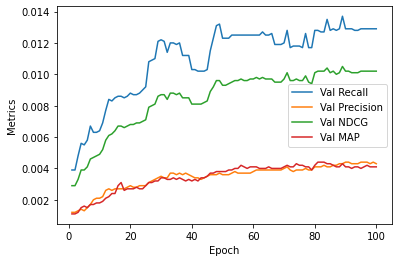

In [23]:
plt.plot(epoch_list, val_recall_list, label='Val Recall')
plt.plot(epoch_list, val_precision_list, label='Val Precision')
plt.plot(epoch_list, val_ndcg_list, label='Val NDCG')
plt.plot(epoch_list, val_map_list, label='Val MAP')
plt.xlabel('Epoch')
plt.ylabel('Metrics')
plt.legend()

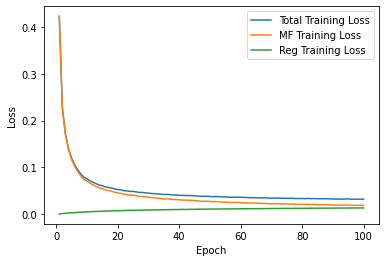

In [24]:
plt.plot(epoch_list, loss_list_epoch, label='Total Training Loss')
plt.plot(epoch_list, MF_loss_list_epoch, label='MF Training Loss')
plt.plot(epoch_list, reg_loss_list_epoch, label='Reg Training Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

In [25]:
print("Average time taken to train an epoch -> ", round(np.mean(train_time_list),2), " seconds")
print("Average time taken to eval an epoch -> ", round(np.mean(eval_time_list),2), " seconds")

Average time taken to train an epoch ->  88.37  seconds
Average time taken to eval an epoch ->  1.31  seconds


In [26]:
print("Last Epoch's Val Recall -> ", val_recall_list[-1])
print("Last Epoch's Val Precision -> ", val_precision_list[-1])
print("Last Epoch's Val NDCG -> ", val_ndcg_list[-1])
print("Last Epoch's Val MAP -> ", val_map_list[-1])

print("Last Epoch's Train Data Loss -> ", loss_list_epoch[-1])

Last Epoch's Val Recall ->  0.0129
Last Epoch's Val Precision ->  0.0043
Last Epoch's Val NDCG ->  0.0102
Last Epoch's Val MAP ->  0.0041
Last Epoch's Train Data Loss ->  0.0319


In [27]:
# Final Test Evaluation using best Val checkpoint (full-corpus exact evaluation)
with torch.no_grad():
    fu_best = torch.load('final_user_Embed.pt', map_location='cpu')
    fi_best = torch.load('final_item_Embed.pt', map_location='cpu')

    # Move to device for fast scoring
    fu_d = fu_best.to(device)
    fi_d = fi_best.to(device)
    test_recall, test_precision, test_ndcg, test_map = get_metrics_full(
        fu_d, fi_d, n_users, n_items, train_pos, test_pos, K, device=device,
        user_batch_size=USER_BATCH_SIZE_FULL, item_chunk_size=ITEM_CHUNK_SIZE_FULL
    )

print("Best checkpoint Test Recall -> ", round(test_recall, 4))
print("Best checkpoint Test Precision -> ", round(test_precision, 4))
print("Best checkpoint Test NDCG -> ", round(test_ndcg, 4))
print("Best checkpoint Test MAP -> ", round(test_map, 4))


Best checkpoint Test Recall ->  0.0139
Best checkpoint Test Precision ->  0.0041
Best checkpoint Test NDCG ->  0.011
Best checkpoint Test MAP ->  0.0057
